# MNIST VAE
29 October 2018



In [1]:
## Add the master directory to the path
import sys
sys.path.append('../')

In [2]:
## Load the relevant modules
import functools
import os

from tqdm import tqdm as tqdm
import torch
from torch.nn import functional as F
from torch import optim
from torch.utils import data
from torchvision import datasets
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

import autoencoders as ae

In [3]:
## Set up the parameters 
params = ae.examples.MnistVaeParams()

params.batch_size = 100
params.test_batch_size = 500
params.num_epochs = 10
params.device = 'cpu'  # change to GPU if you want to train there
params.gaussian_out = False


In [4]:
## Set up the data loaders

# Set up transforms
if not params.gaussian_out:
# commented out below as actually will train for now against the pixel values rather than binarising,
#     # Then we will do Bernoulli. Note that for this example we will simply binarise at 0.5, but to compare with others we should
#     # really pick up a pre-binarised dataset from somewhere else.
#     print("Binarising MNIST")
#     trsfms = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1),
#                                               lambda x: (x > 0.5).type(torch.float32)])
    trsfms = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])
else:
    trsfms = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])

# Create the datasets
dataset = datasets.MNIST('mnist', train=True, download=True,
                                transform=trsfms)
test_dataset = datasets.MNIST('mnist', train=False, download=True,
                         transform=trsfms)

# Create the data loaders.
train_dataloader = data.DataLoader(dataset, batch_size=params.batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=params.batch_size, shuffle=False)


In [5]:
## Set up the training function

def train(data_loader, optimizer, batch_size, device, vae):
    vae.train() # put in train mode
    with tqdm(data_loader, total=len(data_loader.dataset) / batch_size) as t:
        for data_batch in t:
            data_batch_x = data_batch[0].to(device)
            optimizer.zero_grad()
            elbo = vae.elbo(data_batch_x).mean()
            loss = -elbo
            loss.backward()
            optimizer.step()
            t.set_postfix(elbo=elbo.item())  # update the progress bar


In [6]:
## Set up the validation function
def test(data_loader, batch_size, device, vae, epoch_num, plot_reconstructions=True):
    vae.eval()

    elbos_batch_size = []
    start = True
    with tqdm(data_loader, total=len(data_loader.dataset) / batch_size) as t:
        for data_batch in t:
            data_batch_x = data_batch[0].to(device)
            with torch.no_grad():
                elbo = vae.elbo(data_batch_x).mean()
            elbos_batch_size.append((elbo.item(), data_batch_x.shape[0]))

            if plot_reconstructions and start:
                reconstruction_ = vae.reconstruct_no_grad(data_batch_x).cpu()
                img_grid = make_grid(reconstruction_.view(-1,1, 28,28).cpu(), nrow=10).numpy()
                f, ax = plt.subplots(figsize=(8, 8))
                ax.imshow(np.transpose(img_grid, (1,2,0)), vmin=0, vmax=1.)
                plt.show()
                start = False

    avg_elbo = functools.reduce(lambda x, y: ((x[0]*x[1] + y[0]*y[1]) / (x[1] + y[1])  # avg
                                                , x[1] + y[1]),  # total points
                                  elbos_batch_size)
    print(f"Run through the test dataset ({avg_elbo[1]} num of points). Average ELBO was {avg_elbo[0]:.4f}\n")

  0%|          | 0/20.0 [00:00<?, ?it/s]

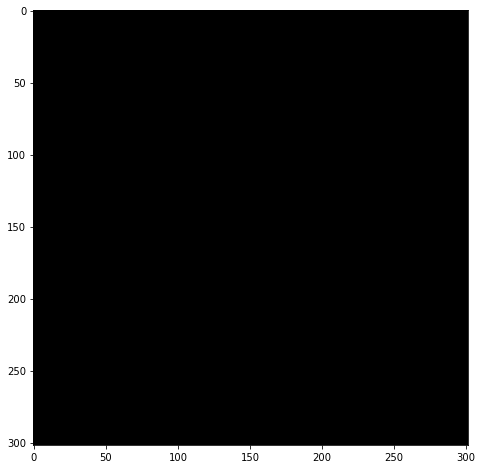

100it [00:01, 52.13it/s]
  0%|          | 3/600.0 [00:00<00:38, 15.63it/s, elbo=-443]

Run through the test dataset (10000 num of points). Average ELBO was -548.7751



Starting epoch 0


100%|██████████| 600/600.0 [00:20<00:00, 29.14it/s, elbo=-132]
  0%|          | 0/20.0 [00:00<?, ?it/s]

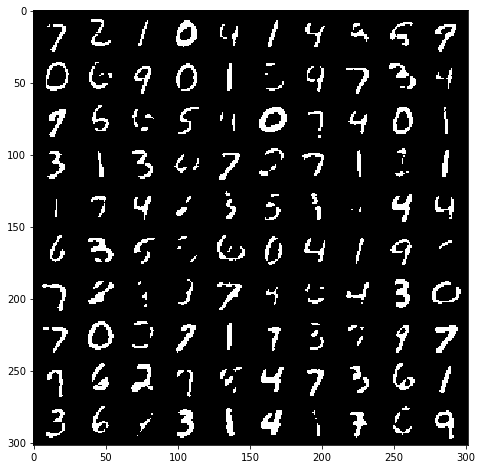

100it [00:01, 65.33it/s]
  0%|          | 3/600.0 [00:00<00:37, 15.86it/s, elbo=-125]

Run through the test dataset (10000 num of points). Average ELBO was -124.1089



Starting epoch 1


100%|██████████| 600/600.0 [00:24<00:00, 24.99it/s, elbo=-120]
  0%|          | 0/20.0 [00:00<?, ?it/s]

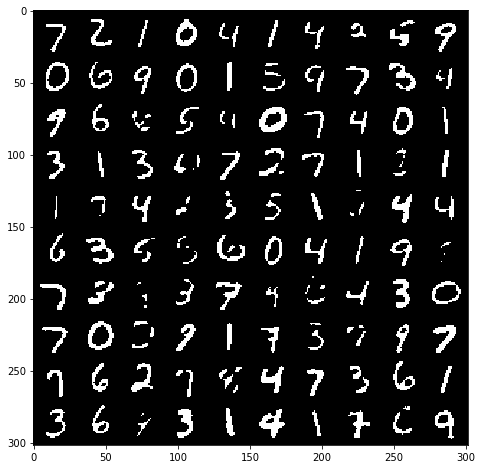

100it [00:01, 63.85it/s]
  0%|          | 3/600.0 [00:00<00:35, 16.97it/s, elbo=-119]

Run through the test dataset (10000 num of points). Average ELBO was -113.9070



Starting epoch 2


100%|██████████| 600/600.0 [00:23<00:00, 25.29it/s, elbo=-112]
  0%|          | 0/20.0 [00:00<?, ?it/s]

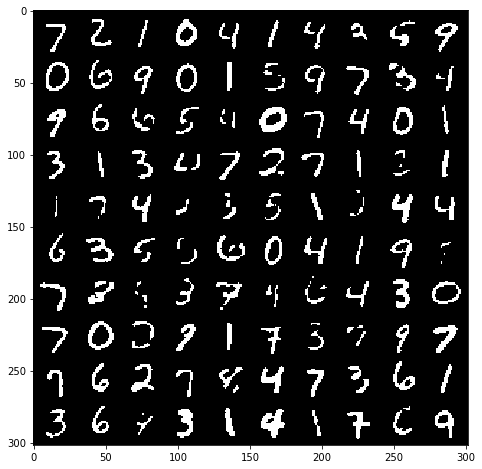

100it [00:01, 66.01it/s]
  0%|          | 3/600.0 [00:00<00:33, 17.92it/s, elbo=-109]

Run through the test dataset (10000 num of points). Average ELBO was -110.6807



Starting epoch 3


100%|██████████| 600/600.0 [00:23<00:00, 25.14it/s, elbo=-110]
  0%|          | 0/20.0 [00:00<?, ?it/s]

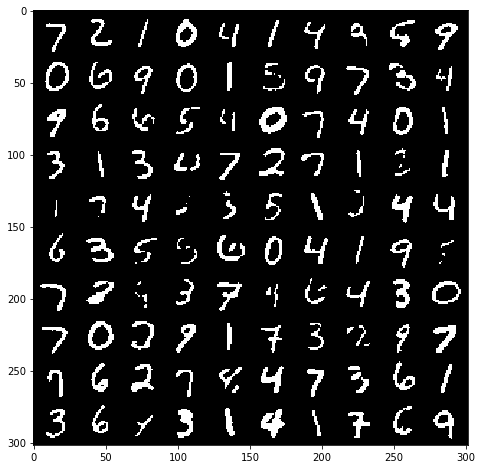

100it [00:01, 64.06it/s]
  0%|          | 3/600.0 [00:00<00:33, 17.75it/s, elbo=-112]

Run through the test dataset (10000 num of points). Average ELBO was -109.0980



Starting epoch 4


100%|██████████| 600/600.0 [00:23<00:00, 25.21it/s, elbo=-112]
  0%|          | 0/20.0 [00:00<?, ?it/s]

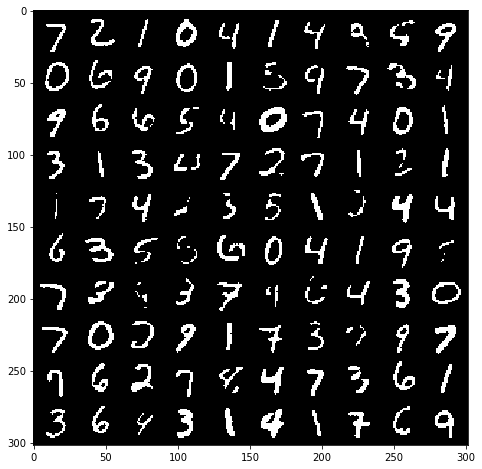

100it [00:01, 65.13it/s]
  0%|          | 3/600.0 [00:00<00:39, 15.27it/s, elbo=-112]

Run through the test dataset (10000 num of points). Average ELBO was -107.9932



Starting epoch 5


100%|██████████| 600/600.0 [00:25<00:00, 23.92it/s, elbo=-107]
  0%|          | 0/20.0 [00:00<?, ?it/s]

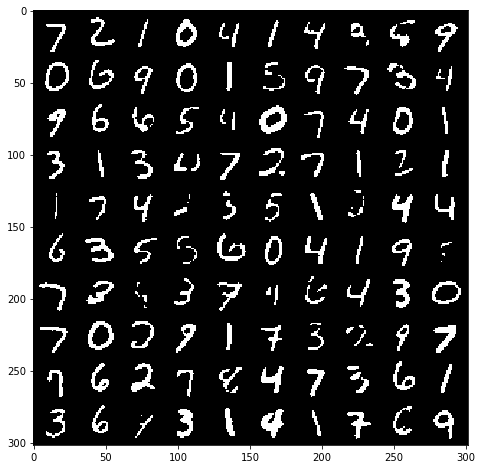

100it [00:01, 63.71it/s]
  0%|          | 3/600.0 [00:00<00:34, 17.28it/s, elbo=-103]

Run through the test dataset (10000 num of points). Average ELBO was -107.4013



Starting epoch 6


100%|██████████| 600/600.0 [00:26<00:00, 22.96it/s, elbo=-109]
  0%|          | 0/20.0 [00:00<?, ?it/s]

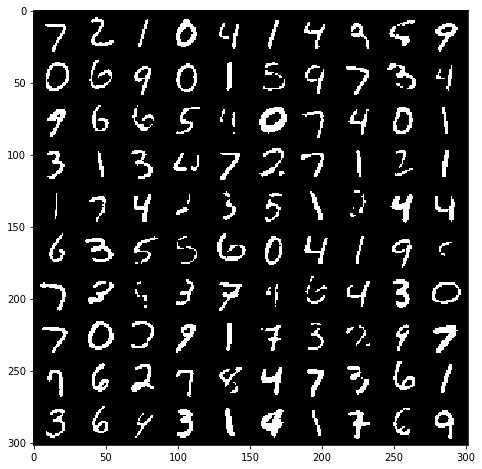

100it [00:01, 62.96it/s]
  0%|          | 3/600.0 [00:00<00:34, 17.39it/s, elbo=-104]

Run through the test dataset (10000 num of points). Average ELBO was -106.7617



Starting epoch 7


100%|██████████| 600/600.0 [00:25<00:00, 23.72it/s, elbo=-103]
  0%|          | 0/20.0 [00:00<?, ?it/s]

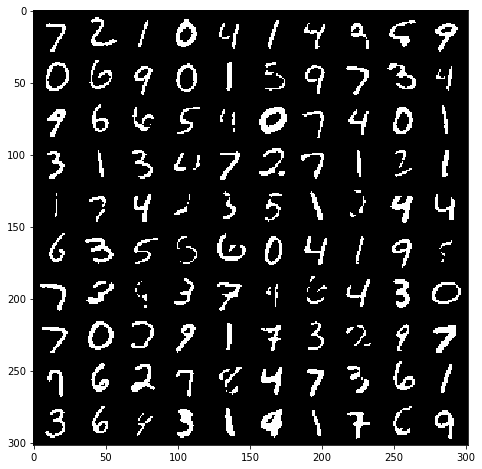

100it [00:01, 57.04it/s]
  0%|          | 3/600.0 [00:00<00:36, 16.55it/s, elbo=-108]

Run through the test dataset (10000 num of points). Average ELBO was -106.3628



Starting epoch 8


100%|██████████| 600/600.0 [00:25<00:00, 23.28it/s, elbo=-107]
  0%|          | 0/20.0 [00:00<?, ?it/s]

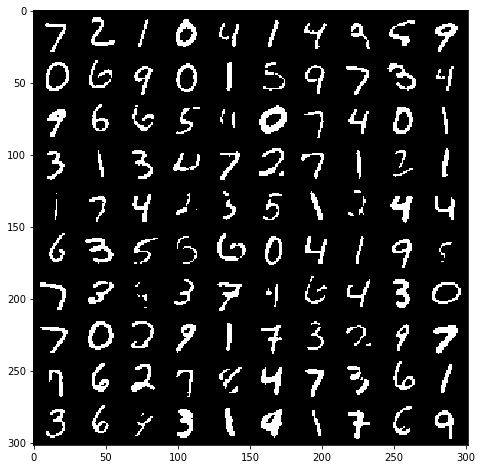

100it [00:01, 54.46it/s]
  0%|          | 3/600.0 [00:00<00:34, 17.39it/s, elbo=-108]

Run through the test dataset (10000 num of points). Average ELBO was -105.8043



Starting epoch 9


100%|██████████| 600/600.0 [00:24<00:00, 24.22it/s, elbo=-101]
  0%|          | 0/20.0 [00:00<?, ?it/s]

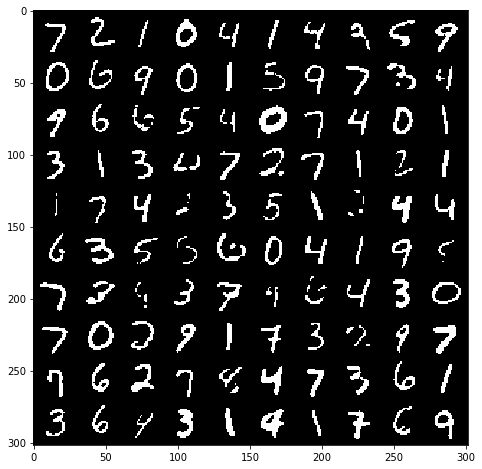

100it [00:02, 49.28it/s]

Run through the test dataset (10000 num of points). Average ELBO was -105.6399

Trained the VAE for 10 epochs.


In [7]:
## Go through and train!
import pdb
torch.manual_seed(14545)

# Create the VAE
vae = ae.examples.create_mnist_vae_model(params)
vae.to(params.device)

# Create the optimizer:
optimizer = optim.Adam(vae.parameters())

# Now go through and train and evaluate per epoch
#pdb.set_trace()
test(test_dataloader, params.test_batch_size, params.device, vae, -1)
for epoch in range(params.num_epochs):
    print(f"\n\nStarting epoch {epoch}")
    train(train_dataloader, optimizer, params.batch_size, params.device, vae)
    test(test_dataloader, params.test_batch_size, params.device, vae, epoch)
print(f"Trained the VAE for {params.num_epochs} epochs.")

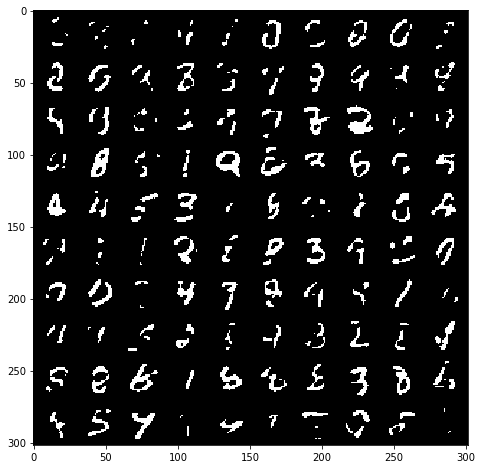

In [8]:
## Now sample from the prior and feed through trained decoder.

num_samples = 100
samples = torch.cat([vae.sample_from_prior_no_grad() for _ in range(num_samples)])
img_grid = make_grid(samples.view(-1,1, 28, 28).cpu(), nrow=10).numpy()
f, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.transpose(img_grid, (1,2,0)), vmin=0, vmax=1.)
plt.show()
start = False

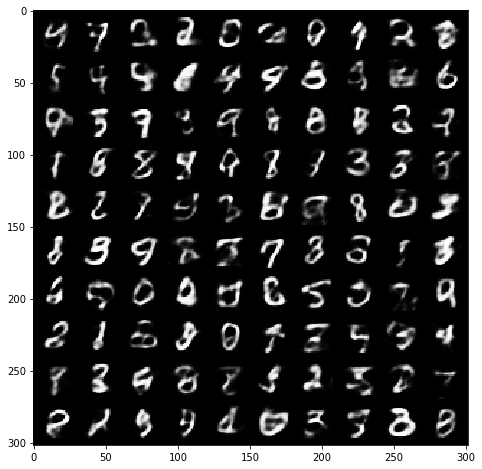

In [9]:
## Note that instead can view the probabilities, rather than the mode of the putput distribution,
# but in order to do this we meed to dig into the background code a bit...
num_samples = 100
with torch.no_grad():
    z_sample = torch.randn(100, params.latent_space_dim)
    vae.decoder.update(z_sample)
    net_out = torch.sigmoid(vae.decoder._net_out)
img_grid = make_grid(net_out.view(-1,1, 28, 28).cpu(), nrow=10).numpy()
f, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.transpose(img_grid, (1,2,0)), vmin=0, vmax=1.)
plt.show()
start = False
